# Speech Reception Threshold (SRT) phenotype (quantitative)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for SRT phenotype to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/hearing_impairment
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## SRT analysis plan

**The phenotypes to be used are as follow:**
1. Left ear f.20019
2. Right ear f.20021
3. Best ear (create a new variable extracting the min SRT value among f.20019 and f.20021)
4. Worst ear (create a new variable extracting the max SRT value among f.20019 and f.20021)
5. Dichotomous trait: 
- controls are those at the bottom 25% for left ear (< -7.5) and right ear (< -7.5)
- cases are those at the top 25% for left (>-5) and right ear (>-5)

**Age is calculated as follows:**

- For people with repeated measures take age at last visit and measurement at last visit
- For people with only one measure take age at that visit

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836

## Load libraries and set working dir

In [ ]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()

In [2]:
#Set working directory
setwd('~/project/HI_UKBB')

## Clean workspace

In [3]:
# Clean workspace
rm(list=ls())

## Filter SRT codes

* Obtain scores for right and left ear
* Obtain the age at the last visit

In [4]:
df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')

In [5]:
head(df.final.imp)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.45,f.41281.0.46,age,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,73,0,0,0,0,0,0,0
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,43,0,0,0,0,0,0,0


In [6]:
#extract the SRT score for left ear and right ear at the last visit for repeaters 

srt_all = df.final.imp %>% 
  select(IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0, f.20019.0.0, f.20019.1.0, f.20019.2.0, f.20019.3.0,f.20021.0.0,f.20021.1.0,f.20021.2.0,f.20021.3.0,f.4270.0.0,f.4270.1.0,f.4270.2.0,f.4270.3.0,f.4277.0.0,f.4277.1.0,f.4277.2.0,f.4277.3.0)


srt_clean <-  srt_all %>% 
  mutate(srt_score_left = apply(select(., starts_with("f.20019")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         srt_score_right = apply(select(., starts_with("f.20021")), 1, function(x) {tail(x[!is.na(x)],n=1)[1]}),
         srt_age =  apply(select(., starts_with("f.21003")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         left_volume =  apply(select(., starts_with("f.4270")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         right_volume =  apply(select(., starts_with("f.4277")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]})
  ) 

In [7]:
head(srt_clean)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4270.3.0,f.4277.0.0,f.4277.1.0,f.4277.2.0,f.4277.3.0,srt_score_left,srt_score_right,srt_age,left_volume,right_volume
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,1000019,1000019,Female,47,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,47,NA,NA
2,1000022,1000022,Male,53,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,53,NA,NA
3,1000035,1000035,Male,63,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,63,NA,NA
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,NA,NA,40%,NA,-6.0,-5,73,70%,40%
5,1000054,1000054,Female,65,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,65,NA,NA
6,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,100% (max),NA,NA,NA,-8.5,-7,43,40%,100% (max)


## Number of individuals with SRT for left and right ear

In [8]:
#NA for both ear (211763 individuals)
srt_NA <- srt_clean %>% 
  filter(is.na(srt_score_left) & is.na(srt_score_right))
cat("There are",nrow(srt_NA)," individuals with missing data for both ears.\n")

There are 211763  individuals with missing data for both ears.


In [9]:
#all people who have left ear score  141029
left_ear <- srt_clean %>% 
  filter(!is.na(srt_score_left))
cat("There are",nrow(left_ear)," individuals with SRT score for the left ear.\n")

There are 141029  individuals with SRT score for the left ear.


In [10]:
#all people who have right ear score  141030 
right_ear <- srt_clean %>% 
  filter(!is.na(srt_score_right))
cat("There are",nrow(right_ear)," individuals with SRT score for the right ear.\n")

There are 141030  individuals with SRT score for the right ear.


In [11]:
#1555 who have srt score for right ear but not for left ear
right_ear_na <- srt_clean %>% 
  filter(!is.na(srt_score_right) & is.na(srt_score_left))
cat("There are",nrow(right_ear_na)," individuals with SRT score for the right ear but not for the left ear.\n")

There are 1555  individuals with SRT score for the right ear but not for the left ear.


In [12]:
#1554 who have srt score for left ear but not for right ear
left_ear_na <- srt_clean %>% 
  filter(!is.na(srt_score_left) & is.na(srt_score_right))
cat("There are",nrow(left_ear_na)," individuals with SRT for left ear but not for right ear.\n")

There are 1554  individuals with SRT for left ear but not for right ear.


In [13]:
#139475 have SRT score for both ears
both_ear <- srt_clean %>% 
   filter(!is.na(srt_score_left) & !is.na(srt_score_right))
cat("There are",nrow(both_ear)," individuals with SRT score for both ears.\n")

There are 139475  individuals with SRT score for both ears.


In [14]:
#142584 have SRT score for either ear 
either_ear <- srt_clean %>% 
   filter(!is.na(srt_score_left) | !is.na(srt_score_right))
cat("There are",nrow(either_ear)," individuals with SRT score for either left or right ears.\n")

There are 142584  individuals with SRT score for either left or right ears.


In [15]:
dim(srt_clean)

[1] 354347     28

## SRT score as categorical variable

In [16]:
### Classification for SRT Score 
#create a categorical variable to classify the score for left and right ear
#138901 have either right or left score, or both  (deleting the outliers #remove the score 8 (outlier) for both ears)
srt_cat <- srt_clean %>% 
    mutate(srt_score_left = ifelse(srt_score_left == 8, NA, srt_score_left),
           srt_score_right = ifelse(srt_score_right == 8, NA, srt_score_right)) %>%
    filter(!is.na(srt_score_left) | !is.na(srt_score_right)) %>% 
    mutate(srt_left_cat = case_when(
        srt_score_left < -5.5   ~  "normal",
        -5.5 <= srt_score_left & srt_score_left <= -3.5   ~  "insufficient",
          srt_score_left > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_right_cat = case_when(
        srt_score_right < -5.5   ~  "normal",
        -5.5 <= srt_score_right & srt_score_right <= -3.5   ~  "insufficient",
          srt_score_right > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) 

nrow(srt_cat)

[1] 142375

In [17]:
#to use the function max/min, replace all NA to -99 for numerical variables 
srt_fill_na <- srt_cat
srt_fill_na$srt_score_left %>% replace_na(-99)
srt_fill_na$srt_score_right %>% replace_na(-99)

[1]  -6.00  -8.50  -4.00  -7.50  -4.00  -6.50  -8.50 -99.00  -4.50 -99.00
   [11]  -6.50 -99.00  -8.50  -5.50  -6.50  -7.00  -6.00  -7.50  -6.00  -8.50
   [21]  -8.00  -5.50  -7.00  -5.50  -9.50  -6.00  -8.00  -8.00  -8.00  -6.50
   [31]  -9.00  -8.00  -4.50  -5.50  -4.50  -6.50  -4.50  -8.50  -5.00  -4.00
   [41]  -8.00  -1.00  -6.00  -5.00  -7.00  -3.50  -5.50  -8.00  -9.50  -9.00
   [51]  -8.50  -5.50  -8.50  -3.50  -6.00  -7.00  -5.50  -6.00  -5.00  -6.50
   [61]  -5.50  -7.50  -5.00  -4.00 -10.00  -3.00  -7.00  -8.00  -5.50  -9.00
   [71]  -7.50  -7.50  -5.50  -7.00  -7.50  -8.00  -4.50  -5.00  -7.00   0.50
   [81]  -6.50  -7.00  -4.00  -5.00   7.50  -7.00  -6.50  -7.50  -6.00  -6.50
   [91]  -4.50  -8.00 -99.00  -5.50  -6.00  -5.50  -9.50  -5.00  -5.50  -8.00
  [101]  -3.00  -5.00  -6.00  -9.00  -6.00  -7.00  -6.50  -9.00  -8.50  -7.50
  [111]  -6.50 -99.00  -4.50  -8.00  -2.00  -7.00  -7.00  -8.00  -8.50  -7.00
  [121]  -5.50  -5.50  -6.50  -8.00  -5.00  -8.00  -4.50  -7.00  -7.00  -7.50
  [131]  -7.50  -6.50  -9.00  -8.50  -7.50  -5.00  -9.50  -6.00  -8.50  -4.00
  [141]  -8.00  -6.50  -8.50  -7.00  -5.50  -8.00  -5.50  -5.50  -5.50  -3.00
  [151]  -2.50  -7.00  -7.00  -5.50  -4.00  -5.50  -6.00  -8.50  -8.00  -7.50
  [161]  -5.50  -7.50  -5.50  -9.00  -7.00  -6.50  -5.50  -9.00 -99.00  -3.50
  [171]  -4.50  -8.50  -5.50  -6.00  -7.50  -4.00  -5.50  -8.00  -8.00  -7.00
  [181]  -2.00  -7.50  -8.00  -3.50  -6.00  -7.00  -7.00  -7.50 -99.00  -8.00
  [191]  -8.50  -6.00  -7.00  -6.50  -7.00  -7.50  -5.00  -6.50  -5.50  -6.00
  [201]  -9.00  -7.50  -6.50  -2.00  -4.50  -6.00  -4.00  -5.50  -8.00  -7.00
  [211]  -8.00  -6.00  -4.50  -8.00  -6.00  -7.00  -6.50  -8.50  -8.00  -5.00
  [221]  -6.50  -4.00  -3.00  -7.00  -8.00  -7.00  -9.00  -7.00  -6.00  -5.00
  [231]  -5.50  -6.50  -7.50  -7.50  -5.50  -7.50  -8.00  -7.00  -8.00  -5.50
  [241]  -5.50  -9.25  -7.00  -5.00 -99.00  -5.50  -7.00  -5.50  -3.00  -7.50
  [251]  -7.00  -7.50   4.50  -6.50  -8.00  -8.00  -5.50  -0.50  -6.00  -6.50
  [261]  -6.50  -4.50  -7.00  -3.50  -6.50  -8.50  -5.50  -8.50  -5.50  -9.00
  [271]  -5.50  -3.50  -9.00  -8.00  -6.00  -7.50  -9.00  -2.50  -7.00  -8.00
  [281]  -6.00  -5.50  -8.00  -7.00  -6.50 -99.00  -7.50  -8.50  -8.50  -7.50
  [291] -10.00  -6.50  -4.00  -5.50  -4.00  -7.50  -8.50  -3.50  -8.50  -5.50
  [301]  -8.00  -6.00  -6.50  -7.50  -6.50  -4.00  -7.00  -5.00  -7.50  -9.00
  [311]  -8.00  -3.00  -8.00  -6.50  -6.50  -6.00   3.00   0.50  -8.50  -5.00
  [321]   4.25  -8.50   4.50  -8.00  -6.00  -8.00  -8.00  -7.50  -8.00  -5.00
  [331]  -5.00  -6.50  -6.00  -4.00  -5.50 -10.00  -8.50  -5.00  -7.00  -7.50
  [341]  -7.00  -8.00  -3.50  -6.00  -7.00  -9.50  -6.50  -5.00  -4.00  -7.50
  [351] -10.50  -6.00  -5.50  -6.00   2.00  -8.00  -4.50  -7.00  -7.50  -6.50
  [361] -10.00  -6.50  -6.00  -6.00  -7.00  -8.50  -4.50  -6.50  -9.50  -8.50
  [371]  -7.50  -5.50  -5.00  -5.50  -5.00  -4.00  -9.00  -8.00  -7.00 -99.00
  [381]  -6.00  -5.00  -6.00  -2.00  -7.00  -5.50  -6.00  -7.00  -8.00  -2.50
  [391]  -9.00  -8.00 -99.00  -6.00  -6.00  -7.00  -6.00  -6.00  -7.50  -5.00
  [401]  -2.00   0.00 -99.00  -7.00  -8.00  -5.50  -6.50  -7.50  -4.50  -7.50
  [411]  -8.00  -6.00  -7.00  -7.50  -9.50  -7.50  -7.00  -7.50  -4.50  -8.00
  [421]  -6.00  -4.50  -5.50  -4.00  -7.00  -8.50  -5.00  -7.50  -7.00  -5.50
  [431]  -5.00  -4.00  -4.00  -2.00  -8.50  -6.00  -2.50  -4.50  -7.00  -4.00
  [441]  -7.00  -9.50  -2.00  -3.00  -6.00  -4.00  -4.00  -8.00  -5.50  -4.00
  [451]  -6.50  -3.50  -4.00  -8.50  -6.00  -7.00  -5.50  -7.50  -4.00  -7.50
  [461]  -9.00  -6.00  -5.50 -10.00  -4.50  -4.00  -4.00  -6.50  -3.50  -7.50
  [471]  -7.00  -5.00  -6.00  -5.00  -8.00  -4.50  -6.50  -5.50  -7.50  -8.00
  [481]  -4.50  -5.00  -8.00  -5.50  -4.50  -7.00  -8.00  -3.50  -7.00  -4.00
  [491]  -7.00  -7.00  -9.50  -7.00  -5.50  -2.50  -8.00  -6.00  -7.50  -7.00
  [501]  -9.50  -1.50  -6.50  -5.00  -7.00  -4.00  -4.50  -8.50   0.50  -6.00
  [511]  -7.50  -9.00  -9.

[1]  -5.00  -7.00  -5.00  -6.50  -4.00  -7.50  -2.50  -3.50  -6.00  -4.00
   [11]  -5.00  -9.00  -8.00  -7.00  -6.50  -8.00  -6.00  -9.00  -7.00  -6.00
   [21]  -6.00  -8.00  -7.00  -8.50  -8.00  -5.50  -8.00  -4.50  -5.50  -7.50
   [31]  -7.50  -7.00  -5.50  -6.00  -5.00  -6.00  -6.00  -7.00  -4.00   1.50
   [41]  -8.50  -7.00  -5.50  -4.50  -9.00  -6.50  -7.50  -5.00  -6.00  -8.50
   [51]  -7.50  -7.50  -8.00  -6.00  -7.50  -7.50  -2.00  -4.00  -5.50  -6.00
   [61]  -7.50  -8.00  -7.00  -6.00  -6.50   0.00  -7.00  -9.50  -4.50  -7.50
   [71]  -7.50  -7.00  -4.00  -7.50  -7.50  -5.50  -4.00  -7.00  -8.00   6.75
   [81]  -3.50  -9.00  -7.50  -8.00  -8.00  -6.50  -6.00  -8.50  -4.00  -6.00
   [91]  -3.00  -4.50   7.50  -3.00  -2.50  -3.00  -6.50  -3.50  -4.50  -5.50
  [101]  -7.00  -7.00  -7.50  -8.00  -6.50  -9.00  -5.50  -7.00  -7.00  -7.00
  [111]  -3.00  -6.00  -6.00  -9.00  -6.00  -2.50  -7.50  -8.00  -4.50  -8.00
  [121]  -8.00  -6.50  -7.00  -6.00  -1.00  -7.50  -6.50  -7.50  -4.50  -8.00
  [131]  -6.50  -6.00  -7.50  -8.50  -7.00  -6.00  -6.50  -7.50  -7.50  -6.50
  [141]  -6.50  -3.50  -7.00  -7.00  -5.50  -8.00  -5.00  -6.00 -99.00  -4.50
  [151]  -4.00  -6.50  -5.50  -8.00  -5.50  -9.50  -8.00  -7.00  -7.50 -99.00
  [161] -10.00  -8.00  -7.50  -9.00  -8.50  -9.00  -5.50  -8.50  -5.50   7.50
  [171]  -7.50  -6.50  -5.00  -7.00  -4.50  -6.50  -6.50  -6.50 -99.00  -6.50
  [181]  -5.00  -5.00  -7.00  -3.50  -7.50  -6.00  -6.50  -9.00  -1.00  -5.50
  [191]  -9.00  -5.50  -7.00  -8.50  -6.00  -6.00  -4.50  -4.00  -4.00  -7.00
  [201]  -8.00  -4.00  -5.50   0.00  -2.50  -6.50  -7.50  -8.00  -9.00  -9.00
  [211]  -6.50  -5.00  -7.50  -1.00  -7.00  -5.00  -8.50  -7.00  -5.50  -7.00
  [221]  -8.00  -7.00  -5.00  -1.50  -7.00  -4.50  -9.00  -7.50  -6.00  -2.50
  [231]  -3.50  -7.50  -6.50  -6.00  -4.50  -7.50  -4.00  -9.50  -6.50  -3.50
  [241]  -9.00  -8.00  -5.50  -6.00  -6.00  -8.00  -9.00  -4.50  -4.50  -8.00
  [251]  -6.50  -6.00  -5.50  -0.50  -8.00  -8.50  -7.00  -6.00  -4.50  -8.00
  [261]  -4.00  -3.50  -6.50  -4.00  -7.50  -6.00  -7.00  -5.00  -5.50  -8.00
  [271]  -1.00  -3.50  -8.00  -8.00  -7.00  -7.50  -5.50  -0.50  -6.50  -6.00
  [281]  -5.00  -2.50  -5.00  -6.00  -4.50  -4.00  -7.00  -7.00  -9.50  -6.50
  [291]  -7.00  -7.50  -6.00  -7.50  -5.00  -8.50  -7.50  -5.00  -7.50  -4.00
  [301]  -8.00  -3.50  -5.00  -6.50  -7.50  -1.50  -8.00  -1.00  -8.00  -6.50
  [311]  -6.00  -6.00  -8.50 -99.00  -5.00  -5.00   6.75  -3.50  -7.00  -7.50
  [321]  -7.00  -7.50   5.50  -7.50  -7.00  -8.50  -9.00  -6.50  -8.00  -2.50
  [331]  -3.00  -4.00  -7.00  -3.50  -3.50 -10.50  -6.50  -4.00  -7.00  -7.00
  [341]  -6.50  -5.50  -4.50  -6.50  -6.00 -99.00  -7.50  -5.00  -6.00  -6.50
  [351]  -8.00  -5.50  -8.00  -5.50  -1.50  -8.50  -3.00  -6.00  -4.50   0.50
  [361]  -7.50  -7.50  -6.50  -4.50  -7.00  -1.00  -6.50  -6.00  -7.00  -9.00
  [371]  -4.50  -7.00  -8.50  -3.00  -5.00  -5.00  -8.50 -10.00  -5.50  -6.50
  [381]  -5.50  -5.00  -6.00  -4.50  -5.00  -4.00  -8.00  -5.50  -6.50  -4.00
  [391] -11.00  -7.00  -5.50  -6.00  -5.00  -4.00  -6.50  -5.50  -5.00  -6.50
  [401]  -5.00  -5.00  -5.00  -7.00  -7.00  -6.00  -4.50  -7.00  -9.00  -7.00
  [411]  -9.00  -3.50  -7.50  -7.50  -6.00  -7.50  -8.00  -1.00  -6.50  -7.00
  [421]  -5.50  -9.00  -6.00  -5.00  -5.00  -7.50  -4.00  -8.50  -7.00  -1.50
  [431]  -6.00  -6.50  -6.00  -6.50  -7.00  -5.00  -1.50  -4.00  -8.00  -4.50
  [441]  -8.00  -9.50  -2.50  -5.00  -7.50  -3.00  -5.00  -7.50  -6.50  -1.00
  [451]  -8.00  -3.50  -3.50  -6.00  -6.00  -3.00  -6.00  -8.00  -7.00 -99.00
  [461]  -8.00  -6.50  -7.50  -7.50  -4.50  -4.50  -6.50  -5.00  -7.00  -5.00
  [471]  -7.00 -99.00  -4.50  -4.00  -5.00  -7.00  -6.50  -4.00  -5.00  -8.00
  [481]  -4.00  -7.50 -10.50  -6.50  -3.00  -7.00  -6.50  -6.50  -5.00  -5.00
  [491]  -3.00  -7.50  -9.00  -4.50  -6.50  -7.00  -8.00  -6.50  -8.00  -6.50
  [501]  -8.00  -2.00  -4.00  -4.50  -8.00  -5.50  -6.50  -3.50  -2.50  -6.00
  [511]  -7.00  -7.00  -8.

In [18]:
# Create two new variables to show the best ear and the worst ear
srt_best_worst <-  srt_fill_na %>% 
  mutate(best = apply(select(., starts_with("srt_score")), 1, function(x) min(x[x!=-99])),
         worst = apply(select(., starts_with("srt_score")), 1, function(x) max(x[x!=-99]))
  )

In [19]:
head(srt_best_worst)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,f.4277.3.0,srt_score_left,srt_score_right,srt_age,left_volume,right_volume,srt_left_cat,srt_right_cat,best,worst
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,NA,-6.0,-5.0,73,70%,40%,normal,insufficient,-6.0,-5.0
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,NA,-8.5,-7.0,43,40%,100% (max),normal,normal,-8.5,-7.0
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,NA,-4.0,-5.0,60,40%,10%,insufficient,insufficient,-5.0,-4.0
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,NA,-7.5,-6.5,54,20%,20%,normal,normal,-7.5,-6.5
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,NA,-4.0,-4.0,68,70%,40%,insufficient,insufficient,-4.0,-4.0
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,NA,-6.5,-7.5,49,10%,10%,normal,normal,-7.5,-6.5


In [20]:
#replace -99 with NA
srt_best_worst <- na_if(srt_best_worst, -99)

## Summary statistics

In [25]:
summary_left <- srt_best_worst %>%
  filter(!is.na(srt_score_left)) %>% 
  summarise(std_left =sd(srt_score_left),
          mean_left = mean(srt_score_left),
          median_left = median(srt_score_left),
          min_left = min(srt_score_left),
          max_left = max(srt_score_left),
          "25%_quantile" = quantile(srt_score_left,probs = 0.25),
          "75%_quantile" = quantile(srt_score_left,probs = 0.75)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Left Ear")

summary_left 



| std_left| mean_left| median_left| min_left| max_left| 25%_quantile| 75%_quantile|
|--------:|---------:|-----------:|--------:|--------:|------------:|------------:|
|     2.06|     -6.28|        -6.5|   -11.25|     7.75|         -7.5|           -5|

In [26]:
summary_right <- srt_best_worst %>%
  filter(!is.na(srt_score_right)) %>% 
  summarise(std_right =sd(srt_score_right),
          mean_right = mean(srt_score_right),
          median_right = median(srt_score_right),
          min_right = min(srt_score_right),
          max_right = max(srt_score_right),
          "25%_quantile" = quantile(srt_score_right,probs = 0.25),
          "75%_quantile" = quantile(srt_score_right,probs = 0.75)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Right Ear")

summary_right 



| std_right| mean_right| median_right| min_right| max_right| 25%_quantile| 75%_quantile|
|---------:|----------:|------------:|---------:|---------:|------------:|------------:|
|      2.06|      -6.24|         -6.5|    -11.25|      7.75|         -7.5|           -5|

In [27]:
summary_best <- srt_best_worst %>%
  filter(!is.na(best)) %>% 
  summarise(std_best =sd(best),
          mean_best = mean(best),
          median_best = median(best),
          min_best = min(best),
          max_best = max(best),
          "5%_quantile" = quantile(best,probs = 0.05),
          "25%_quantile" = quantile(best,probs = 0.25),
          "75%_quantile" = quantile(best,probs = 0.75),
          "95%_quantile" = quantile(best,probs = 0.95)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Best Ear")

summary_best 



| std_best| mean_best| median_best| min_best| max_best| 5%_quantile| 25%_quantile| 75%_quantile| 95%_quantile|
|--------:|---------:|-----------:|--------:|--------:|-----------:|------------:|------------:|------------:|
|     1.71|     -7.03|          -7|   -11.25|     7.75|        -9.5|           -8|           -6|           -4|

In [28]:
summary_worst <- srt_best_worst %>%
  filter(!is.na(worst)) %>% 
  summarise(std_worst =sd(worst),
          mean_worst = mean(worst),
          median_worst = median(worst),
          min_worst = min(worst),
          max_worst = max(worst),
          "5%_quantile" = quantile(worst,probs = 0.05),
          "25%_quantile" = quantile(worst,probs = 0.25),
          "75%_quantile" = quantile(worst,probs = 0.75),
          "95%_quantile" = quantile(worst,probs = 0.95)
          ) %>% 
  knitr::kable(digits = 2,caption = "Summary Table for Worst Ear")

summary_worst



| std_worst| mean_worst| median_worst| min_worst| max_worst| 5%_quantile| 25%_quantile| 75%_quantile| 95%_quantile|
|---------:|----------:|------------:|---------:|---------:|-----------:|------------:|------------:|------------:|
|      2.12|      -5.47|           -6|     -10.5|      7.75|          -8|           -7|         -4.5|           -2|

## STR binary: bottom 25% as controls and top 75% as cases

In [29]:
#controls: left ear: 25% < -7.5 & right ear: 25% < -7.5 
#cases: left ear: 75% > -5  & right ear: 75% > -5

srt_best_worst <- srt_best_worst %>% 
  filter(!is.na(left_volume) | !is.na(right_volume)) %>% 
   mutate(srt_cat = case_when(
      srt_score_left < -7.5 & srt_score_right < -7.5 ~"control",
      srt_score_left > -5 & srt_score_right > -5 ~"case"),
      left_volume = recode(left_volume,"100% (max)"="1","10%"="0.1","20%"="0.2","40%"="0.4","70%"="0.7"),
      right_volume = recode(right_volume,"100% (max)"="1","10%"="0.1","20%"="0.2","40%"="0.4","70%"="0.7")
   )
nrow(srt_best_worst)
head(srt_best_worst)

[1] 142375

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,srt_score_left,srt_score_right,srt_age,left_volume,right_volume,srt_left_cat,srt_right_cat,best,worst,srt_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,-6.0,-5.0,73,0.7,0.4,normal,insufficient,-6.0,-5.0,NA
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,-8.5,-7.0,43,0.4,1,normal,normal,-8.5,-7.0,NA
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,-4.0,-5.0,60,0.4,0.1,insufficient,insufficient,-5.0,-4.0,NA
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,-7.5,-6.5,54,0.2,0.2,normal,normal,-7.5,-6.5,NA
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,-4.0,-4.0,68,0.7,0.4,insufficient,insufficient,-4.0,-4.0,case
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,-6.5,-7.5,49,0.1,0.1,normal,normal,-7.5,-6.5,NA


In [30]:
#25899 who are classified as either case or control
check_case_control <- srt_best_worst %>% 
  filter(!is.na(srt_cat))
nrow(check_case_control)

[1] 23625

## Obtain the mean between the left and right volume

In [33]:
srt_best_worst <- srt_best_worst %>% 
  mutate(left_volume = as.numeric(left_volume),
         right_volume =  as.numeric(right_volume)) %>% 
  mutate(mean = rowMeans(.[27:28]))
head(srt_best_worst)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.20019.0.0,f.20019.1.0,f.20019.2.0,⋯,srt_score_right,srt_age,left_volume,right_volume,srt_left_cat,srt_right_cat,best,worst,srt_cat,mean
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,1000046,1000046,Female,62,NA,73,NA,NA,NA,-6,⋯,-5.0,73,0.7,0.4,normal,insufficient,-6.0,-5.0,NA,0.55
2,1000063,1000063,Male,43,NA,NA,NA,-8.5,NA,NA,⋯,-7.0,43,0.4,1.0,normal,normal,-8.5,-7.0,NA,0.70
3,1000078,1000078,Female,52,57,60,NA,NA,-5,-4,⋯,-5.0,60,0.4,0.1,insufficient,insufficient,-5.0,-4.0,NA,0.25
4,1000105,1000105,Female,54,NA,NA,NA,-7.5,NA,NA,⋯,-6.5,54,0.2,0.2,normal,normal,-7.5,-6.5,NA,0.20
5,1000112,1000112,Male,58,NA,68,NA,NA,NA,-4,⋯,-4.0,68,0.7,0.4,insufficient,insufficient,-4.0,-4.0,case,0.55
6,1000141,1000141,Female,49,NA,NA,NA,-6.5,NA,NA,⋯,-7.5,49,0.1,0.1,normal,normal,-7.5,-6.5,NA,0.10


In [31]:
length(which(is.na(srt_best_worst$left_volume)))

[1] 785

In [32]:
length(which(is.na(srt_best_worst$right_volume)))

[1] 753

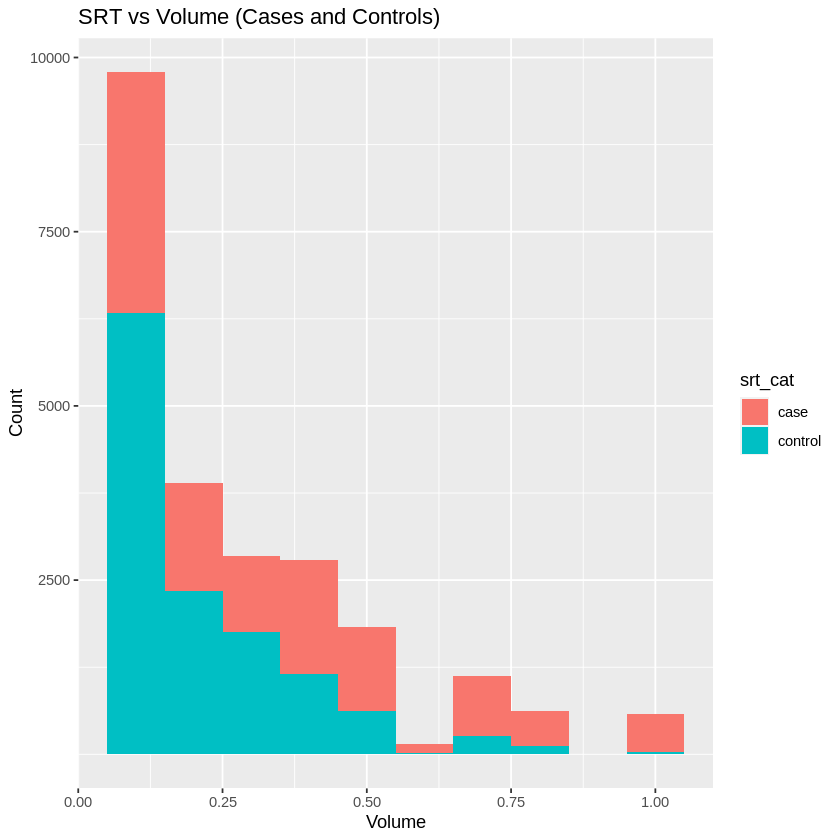

In [38]:
volume_srt <- srt_best_worst %>% 
  filter(!is.na(srt_cat)) %>% 
   ggplot(aes(x = mean,fill = srt_cat)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Cases and Controls)",
    x = "Volume",
    y = "Count"
    ) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500),
    labels = c("2500", "5000", "7500", "10000", "12500"))

volume_srt

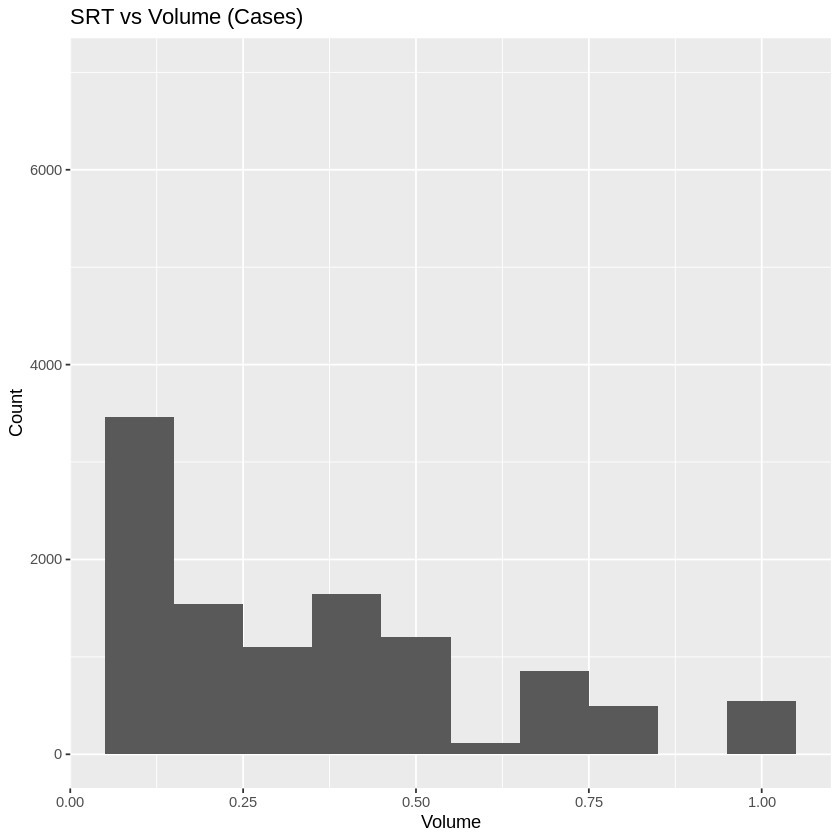

In [39]:
volume_case <- srt_best_worst %>% 
  filter(srt_cat == "case") %>% 
   ggplot(aes(x = mean)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Cases)",
    x = "Volume",
    y = "Count"
    ) + ylim(0,7000)

volume_case

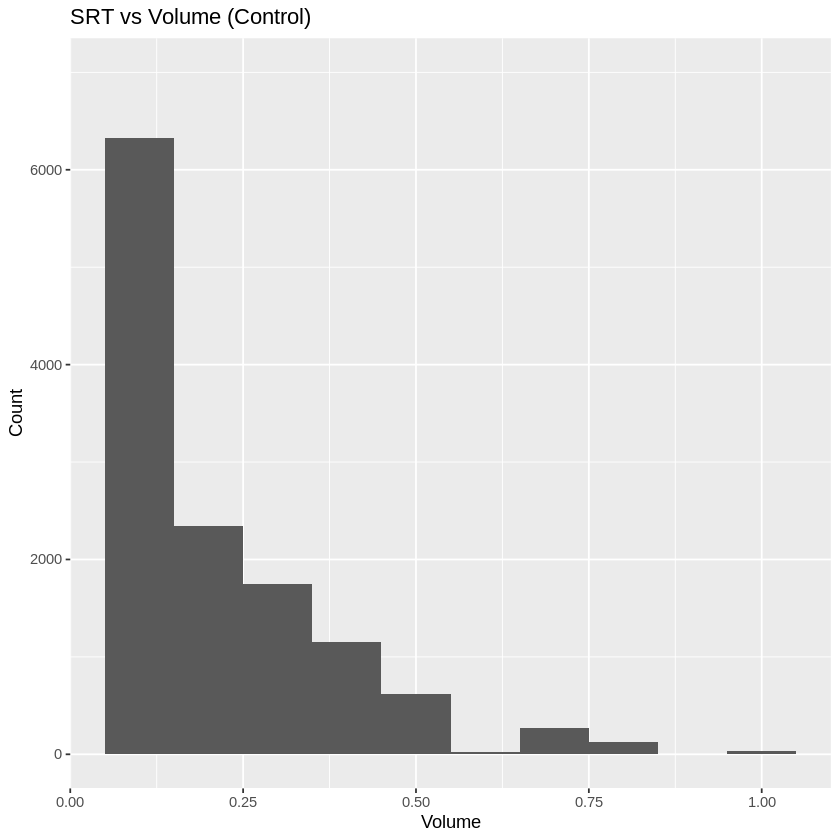

In [40]:
volume_control <- srt_best_worst %>% 
  filter(srt_cat == "control") %>% 
   ggplot(aes(x = mean)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT vs Volume (Control)",
    x = "Volume",
    y = "Count"
    ) + ylim(0,7000)

volume_control

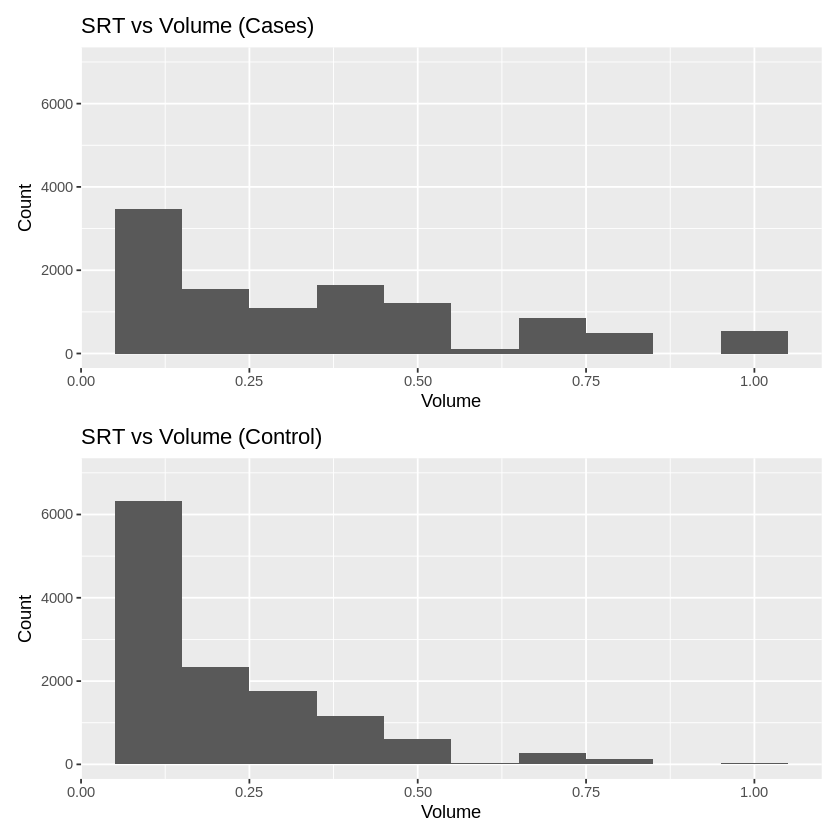

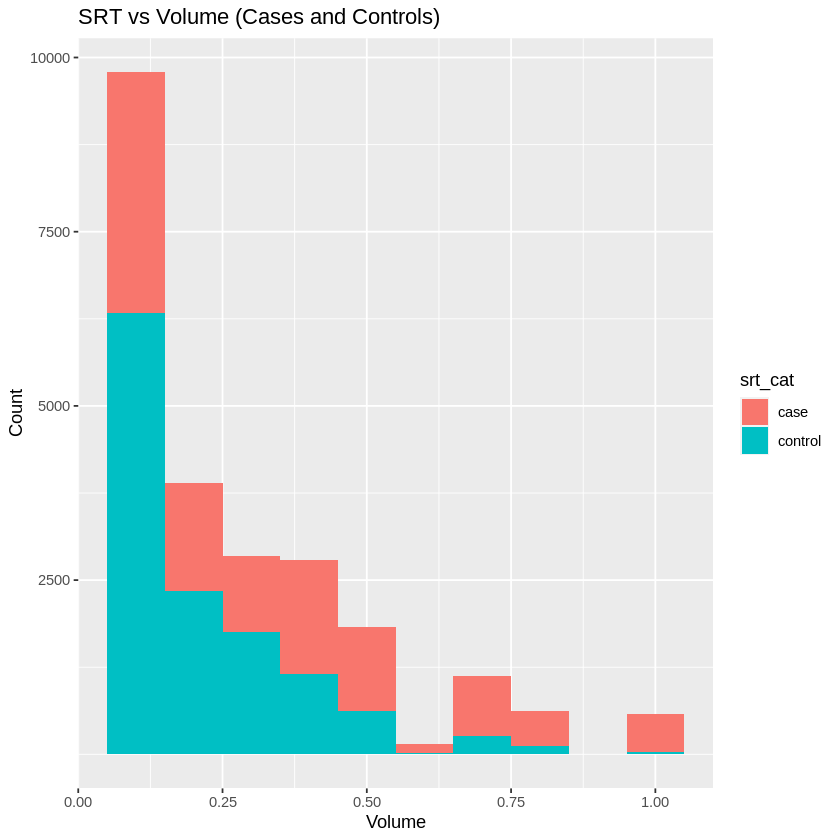

In [41]:
#install.packages("patchwork")
library(patchwork)
volume_case/ volume_control
volume_srt

## Plots

In [ ]:
#histogram for SRT Score for Left Ear
left_plot = srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(x = srt_score_left,fill = srt_left_cat)) +
      geom_histogram(binwidth = 0.25) +
   labs(
    title = "SRT Score for Left Ear (by category)",
    x = "SRT Score for Left ",
    y = "Count"
    ) +  
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000"))
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

In [44]:
#histogram for SRT Score for Right Ear 
right_plot <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(x = srt_score_right, fill=srt_right_cat) ) +
      geom_histogram(binwidth =  0.25) +
  labs(
    title = "SRT Score for Right Ear (by category)",
    x = "SRT Score for Right ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

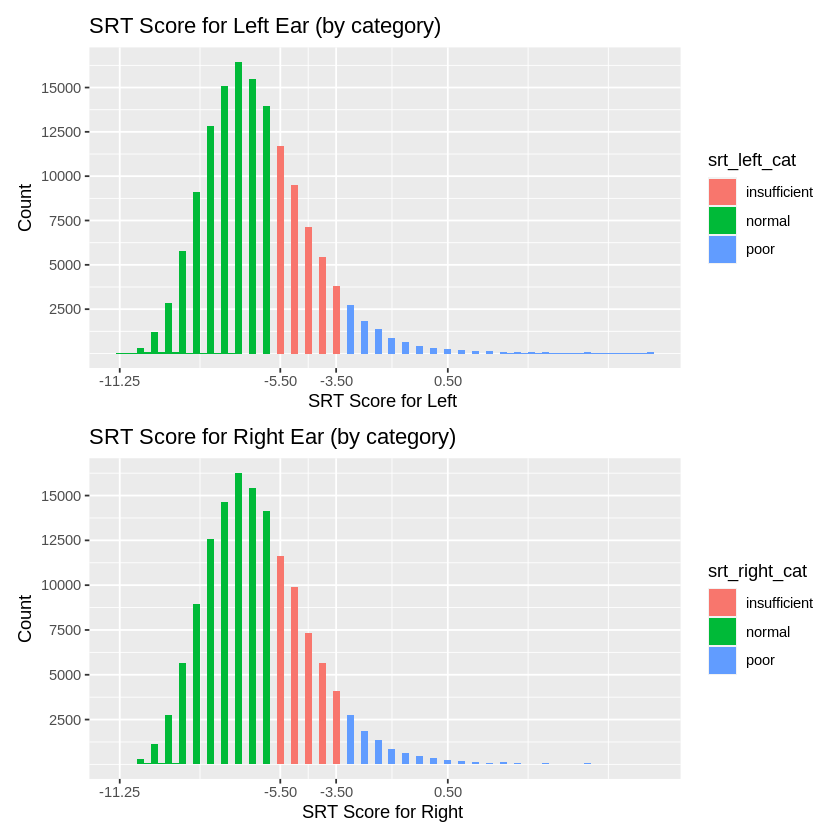

In [45]:
library(patchwork)
left_plot / right_plot

## Normality test for SRT

In [46]:
#install.packages("nortest")
library(nortest)
ad.test(srt_best_worst$srt_score_right)
ad.test(srt_best_worst$srt_score_left)
ad.test(srt_best_worst$best)
ad.test(srt_best_worst$worst)


	Anderson-Darling normality test

data:  srt_best_worst$srt_score_right
A = 1702, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$srt_score_left
A = 1822, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$best
A = 1516.6, p-value < 2.2e-16



	Anderson-Darling normality test

data:  srt_best_worst$worst
A = 2504.1, p-value < 2.2e-16


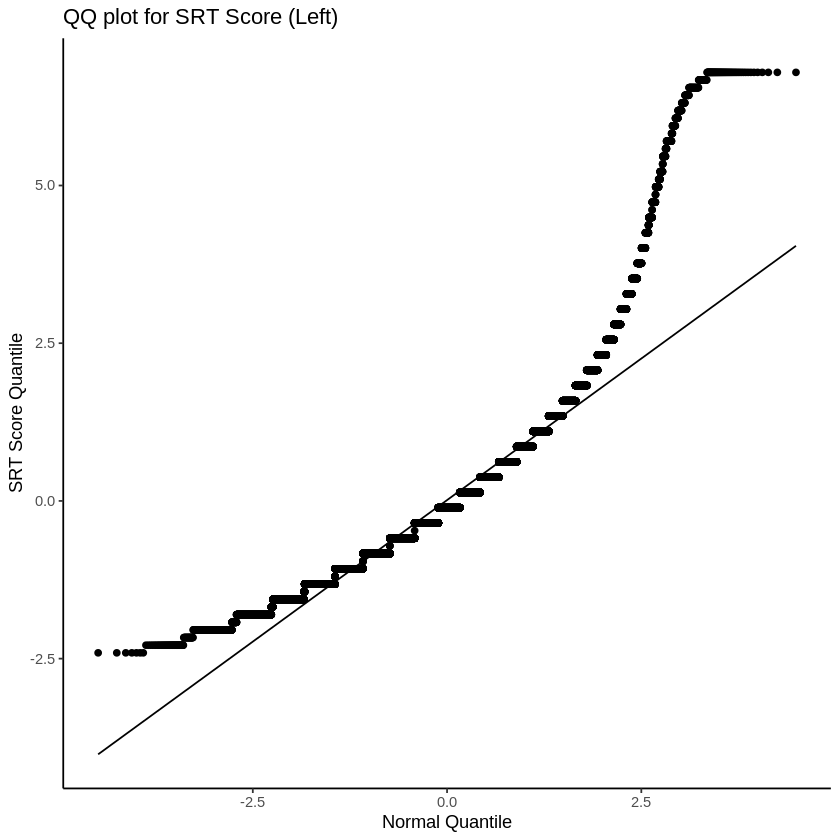

In [47]:
#QQ plot for SRT Score for Left Ear
qq_left_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left))) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_total

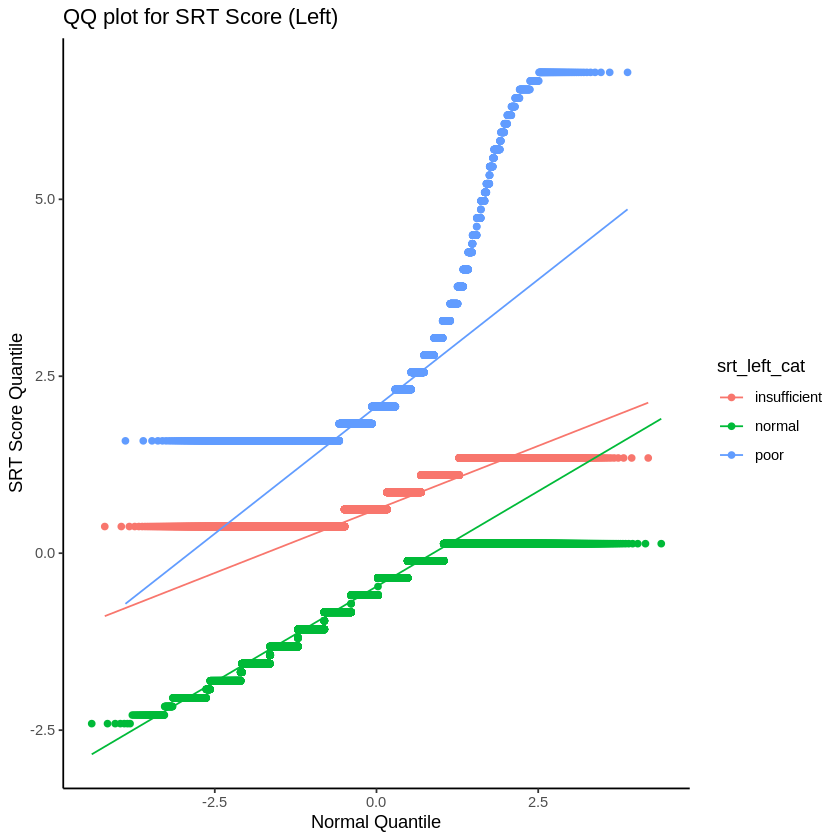

In [48]:
qq_left_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left), color = srt_left_cat)) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_by_cat

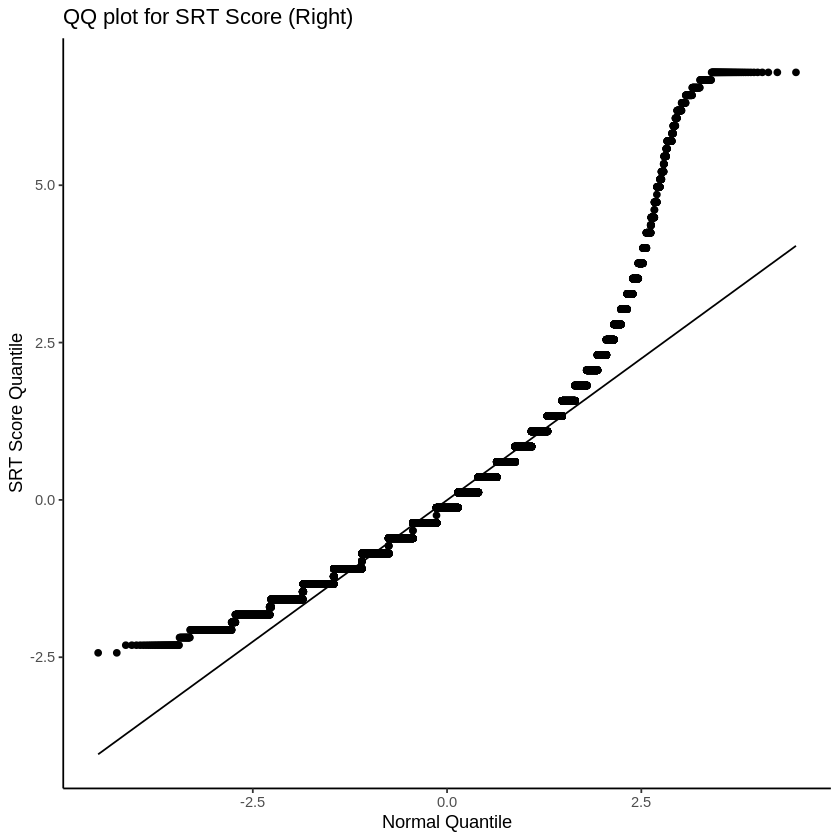

In [49]:
#QQ plot for SRT Score for Right Ear
qq_right_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_total

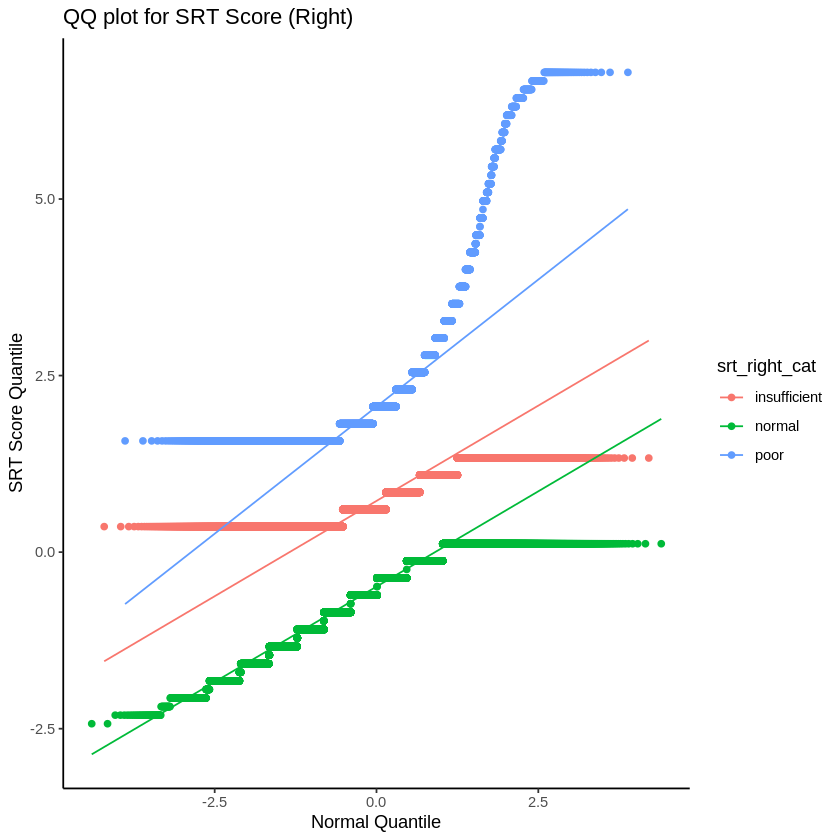

In [50]:
qq_right_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right), color = srt_right_cat)) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_by_cat

In [51]:
##Plots for Best and Worst Ear
srt_best_worst_cat <- srt_best_worst %>%
  mutate(srt_best_cat = case_when(
        best < -5.5   ~  "normal",
        -5.5 <= best & best <= -3.5   ~  "insufficient",
          best > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_worst_cat = case_when(
        worst < -5.5   ~  "normal",
        -5.5 <= worst & worst <= -3.5   ~  "insufficient",
          worst > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  filter(!is.na(best) | !is.na(worst))

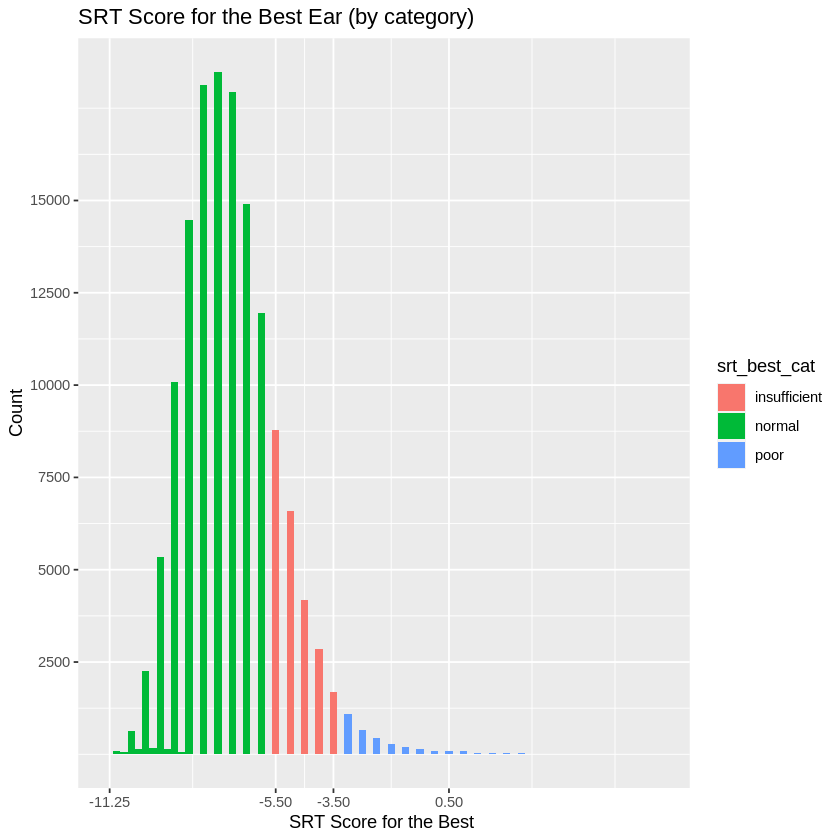

In [52]:
best_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = best, fill = srt_best_cat)) +
      geom_histogram(binwidth = 0.25) +
  labs(
    title = "SRT Score for the Best Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 
best_plot

In [53]:
worst_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = worst, fill = srt_worst_cat)) +
      geom_histogram(binwidth = 0.25) +
  labs(
    title = "SRT Score for the Worst Ear (by category)",
    x = "SRT Score for the Worst ",
    y = "Count"
    ) + 
  scale_x_continuous(
    breaks = c(-11.25, -5.5, -3.5, 0.5)) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
   scale_color_manual("SRT Score Category",labels = c("normal","insufficient","poor"), values = c("green", "red", "blue")) 

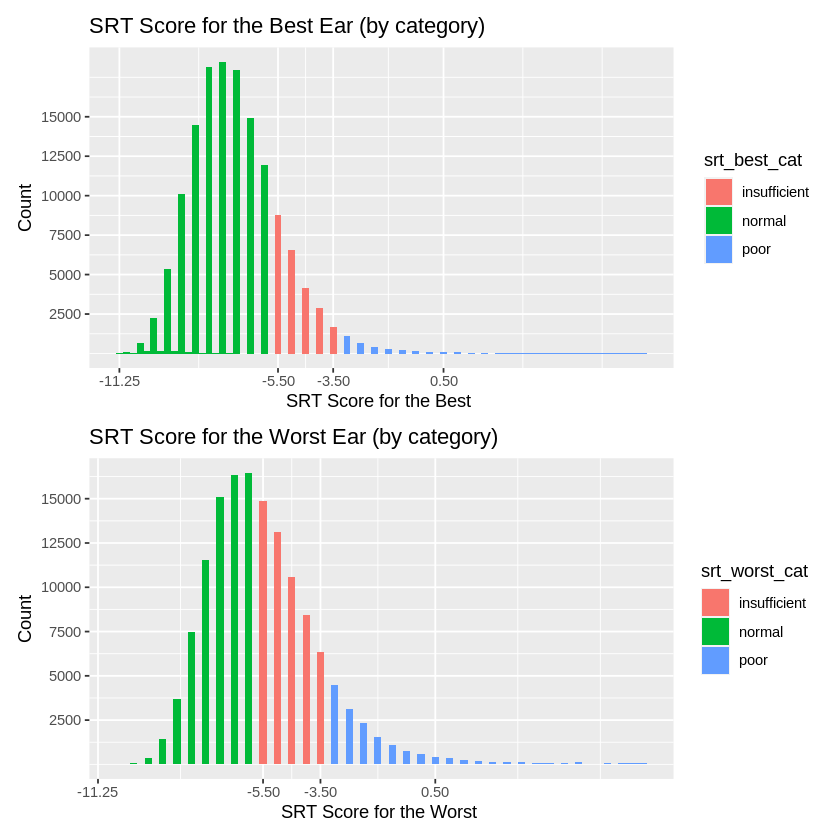

In [219]:
best_plot/worst_plot

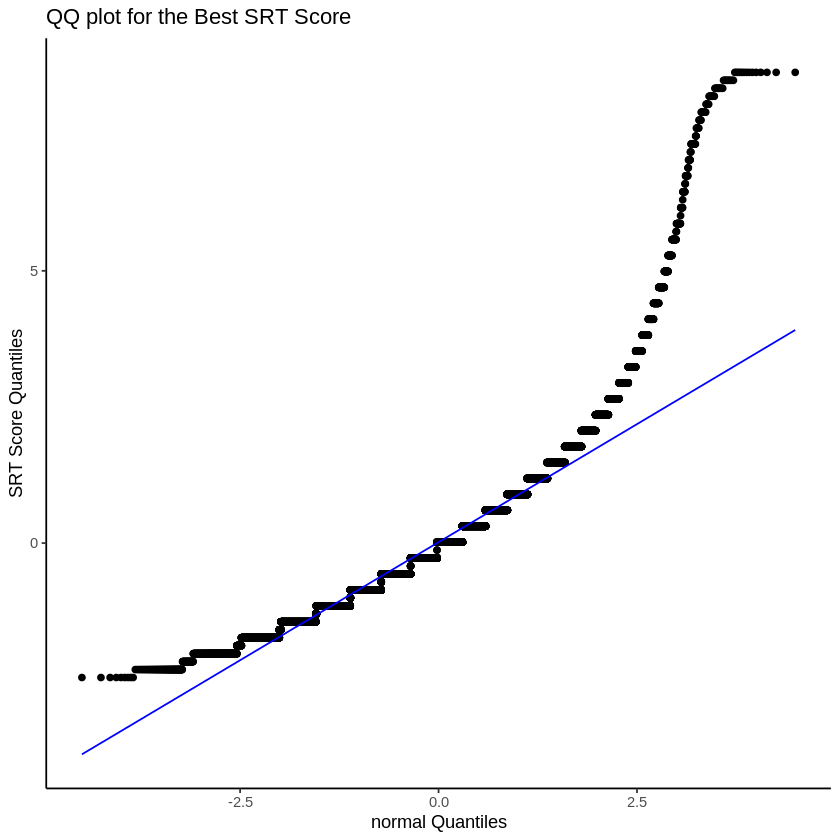

In [54]:
qq_best <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (best - mean(best))/sd(best))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Best SRT Score",
       y = "SRT Score Quantiles",
       x = "normal Quantiles") + 
theme_classic()  

qq_best

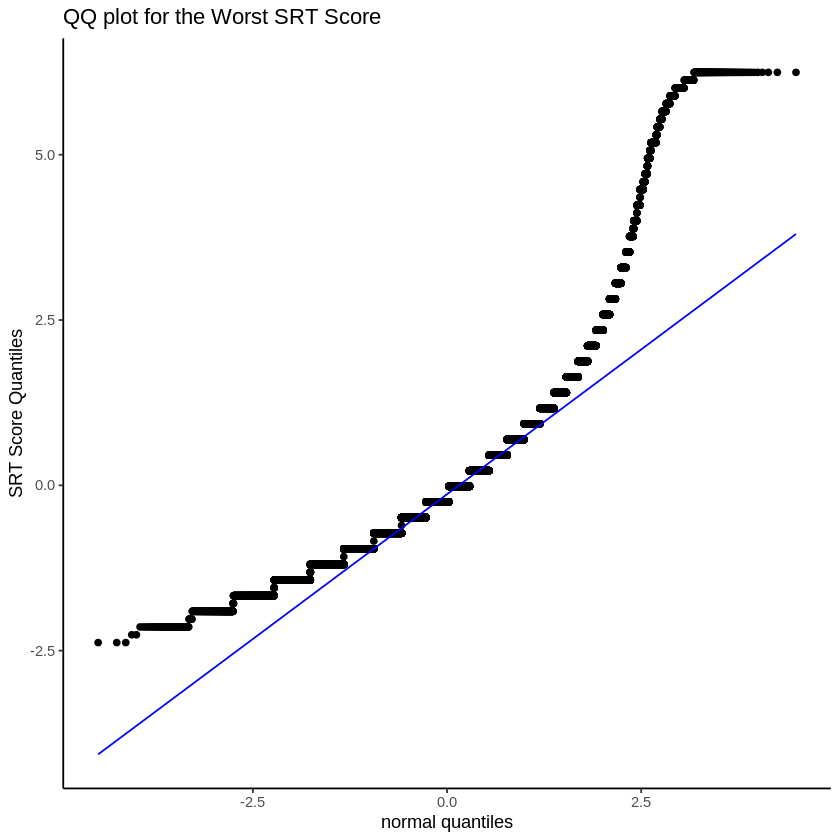

In [221]:
qq_worst <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (worst - mean(worst))/sd(worst))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Worst SRT Score",
       y = "SRT Score Quantiles",
       x = "normal quantiles") +
theme_classic()  

qq_worst